# Texas Income and Education Status vs Gun Violence Data

We will be taking a look at the geogrpahic location of gun violence incidents and over laying them with a chlorepleth map of Texas income and education census tracts. By doing this we can see if there is a correlation to where gun violence incidents occur and where income/education is lower/higher.

We will now install the libraries needed to read/wrangle data, create spacial data, and overlay maps

In [1]:
import geopandas as gpd
import contextily as ctx
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px

import osmnx as ox
import pandas as pd

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Texas Income Comparison
We will be importing our first set of data which is the Texas census income tracts

In [2]:
texasInc = gpd.read_file('acs2019_5yr_B19001_05000US48191.geojson')

we will clean the data by removing the first two outliers, the US data and the overall state of Texas data

In [3]:
texasInc = texasInc.drop([0])
texasInc = texasInc.drop([1])

Trim down the columns

In [4]:
list(texasInc)
columns_to_keep = ['geoid',
 'name',
 'B19001001',
 'B19001002',
 'B19001003',
 'B19001004',
 'B19001005',
 'B19001006',
 'B19001007',
 'B19001008',
'B19001009',
 'B19001010',
 'B19001011',
 'B19001012',
 'B19001013',
 'B19001014',
 'B19001015',
 'B19001016',
 'B19001017',
 'geometry']
texasInc = texasInc[columns_to_keep]

Rename the columns so they are usable and check to see if altered correctly

In [5]:
texasInc.columns = ['geoid',
 'name',
 'Total',
 'Less than $10,000',
 '10,000 to $14,999',
 '15,000 to $19,999',
 '20,000 to $24,999',
 '25,000 to $29,999',
 '30,000 to $34,999',
 '35,000 to $39,999',
 '40,000 to $44,999',
 '45,000 to $49,999',
 '50,000 to $59,999',
 '60,000 to $74,999',
 '75,000 to $99,999',
 '100,000 to $124,999',
 '$125,000 to $149,999',
 '150,000 to $199,999',
 '$200,000 or more',
 'geometry']
texasInc.head()

,geoid,name,Total,"Less than $10,000","10,000 to $14,999","15,000 to $19,999","20,000 to $24,999","25,000 to $29,999","30,000 to $34,999","35,000 to $39,999","40,000 to $44,999","45,000 to $49,999","50,000 to $59,999","60,000 to $74,999","75,000 to $99,999","100,000 to $124,999","$125,000 to $149,999","150,000 to $199,999","$200,000 or more",geometry
2,05000US48001,"Anderson County, TX",16677.0,861.0,1302.0,1259.0,1118.0,897.0,1218.0,1171.0,814.0,734.0,1588.0,1714.0,1831.0,943.0,574.0,411.0,242.0,"MULTIPOLYGON (((-95.67753 32.05163, -95.67360 ..."
3,05000US48003,"Andrews County, TX",5573.0,272.0,188.0,146.0,114.0,293.0,212.0,165.0,355.0,125.0,332.0,496.0,1003.0,573.0,473.0,401.0,425.0,"MULTIPOLYGON (((-102.86649 32.08714, -102.8666..."
4,05000US48005,"Angelina County, TX",31035.0,2102.0,1738.0,1890.0,1915.0,2381.0,1466.0,1336.0,1206.0,1358.0,2980.0,3215.0,4206.0,2283.0,1068.0,1203.0,688.0,"MULTIPOLYGON (((-94.86268 31.23236, -94.86227 ..."
5,05000US48007,"Aransas County, TX",9548.0,854.0,557.0,450.0,578.0,666.0,550.0,677.0,425.0,474.0,589.0,707.0,985.0,731.0,345.0,379.0,581.0,"MULTIPOLYGON (((-97.20401 28.08081, -97.19783 ..."
6,05000US48009,"Archer County, TX",3452.0,158.0,209.0,169.0,184.0,166.0,196.0,124.0,93.0,125.0,196.0,376.0,442.0,359.0,240.0,208.0,207.0,"MULTIPOLYGON (((-98.75200 33.39587, -98.75494 ..."


Now I will normalize the raw data and add colums to my data that give %’s of each income level

In [6]:
texasInc['Percent Less than $10,000'] = texasInc['Less than $10,000']/texasInc['Total']*100
texasInc['Percent 10,000 to $14,999'] = texasInc['10,000 to $14,999']/texasInc['Total']*100
texasInc['Percent 15,000 to $19,999'] = texasInc['15,000 to $19,999']/texasInc['Total']*100
texasInc['Percent 20,000 to $24,999'] = texasInc['20,000 to $24,999']/texasInc['Total']*100 
texasInc['Percent 30,000 to $34,999'] = texasInc['30,000 to $34,999']/texasInc['Total']*100
texasInc['Percent 35,000 to $39,999'] = texasInc['35,000 to $39,999']/texasInc['Total']*100
texasInc['Percent 40,000 to $44,999'] = texasInc['40,000 to $44,999']/texasInc['Total']*100 
texasInc['Percent 45,000 to $49,999'] = texasInc['45,000 to $49,999']/texasInc['Total']*100
texasInc['Percent 50,000 to $59,999'] = texasInc['50,000 to $59,999']/texasInc['Total']*100
texasInc['Percent 60,000 to $74,999'] = texasInc['60,000 to $74,999']/texasInc['Total']*100
texasInc['Percent 75,000 to $99,999'] = texasInc['75,000 to $99,999']/texasInc['Total']*100 
texasInc['Percent 100,000 to $124,999'] = texasInc['100,000 to $124,999']/texasInc['Total']*100
texasInc['Percent $125,000 to $149,999'] = texasInc['$125,000 to $149,999']/texasInc['Total']*100 
texasInc['Percent 150,000 to $199,999'] = texasInc['150,000 to $199,999']/texasInc['Total']*100
texasInc['Percent $200,000 or more'] = texasInc['$200,000 or more']/texasInc['Total']*100 

show the census tract groups in texas using black lines

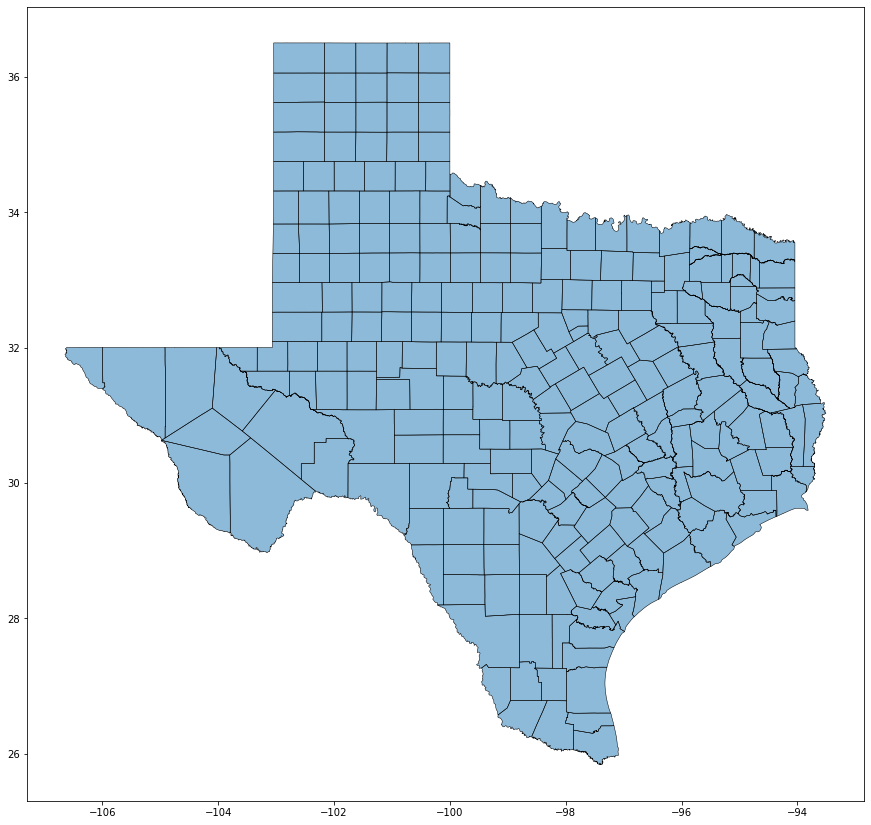

In [7]:
fig,ax = plt.subplots(figsize=(15,15))
texasInc.plot(ax=ax,zorder=10,alpha=.5)
texasInc.boundary.plot(ax=ax,color='black',zorder=15,lw=0.5)

we will now project the data onto a mercator map

In [8]:
texasInc = texasInc.to_crs(epsg=3857)


plot. turn off the axis, and add a base map

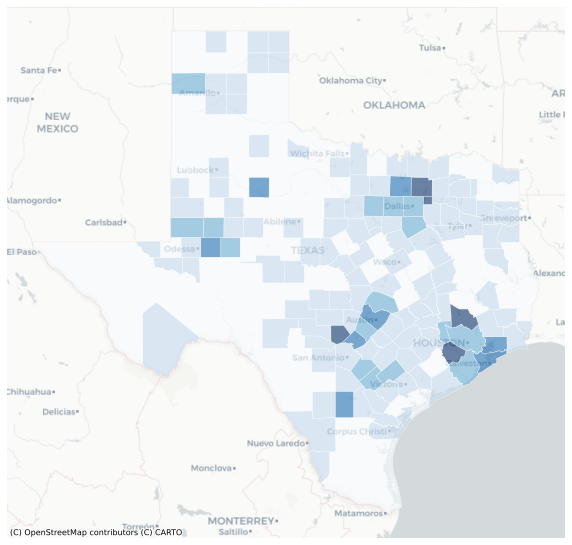

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

texasInc.plot(column='Percent $200,000 or more', 
            cmap= 'Blues', 
            scheme='equal_interval',
            k=5, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.6, 
            ax=ax
           )
ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Texas Income vs Gun Violence Incidents
we will now compare the gun violence incidents as a scatterplot map to the chloropleth income map

import the gun violence data

In [10]:
gvTexas = gpd.read_file('cleanGunData.csv')

clean the data so we only have the geospatial aspect

In [11]:
gvTexas = gvTexas[[
 'latitude',
 'longitude']]
gvTexas

,latitude,longitude
0,29.6754,-95.5499
1,32.7157,-97.2597
2,32.8958,-96.8986
3,32.6412,-96.9481
4,32.2337,-96.4661
...,...,...
13572,29.5287,-98.5612
13573,29.6872,-95.2024
13574,33.9052,-98.5151
13575,32.6772,-96.8059


convert the string type data to usable float data

In [12]:
gvTexas['latitude'] = pd.to_numeric(gvTexas['latitude'],errors='coerce')
gvTexas['longitude'] = pd.to_numeric(gvTexas['longitude'],errors='coerce')


convert from pandas to geopandas dataframe

In [13]:
gvTexas = gpd.GeoDataFrame(gvTexas, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(gvTexas.longitude, gvTexas.latitude))

projec the data onto a mercator map

In [14]:
gvTexas = gvTexas.to_crs(epsg=3857)


now apply the bounds of Texas

In [15]:
minx, miny, maxx, maxy = texasInc.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-11871739.008039713
-10409267.286557566
2978926.9455577526
4369738.002232756


now we set up a plot canvas using plt.subplots. we plot the texas income census tract and texas gun violence data. we use the bounding box coodinates from earlier to set the x and y limits and add an agrument to create a margin around the total bounds. finally, no axis and add chloropleth basemap.

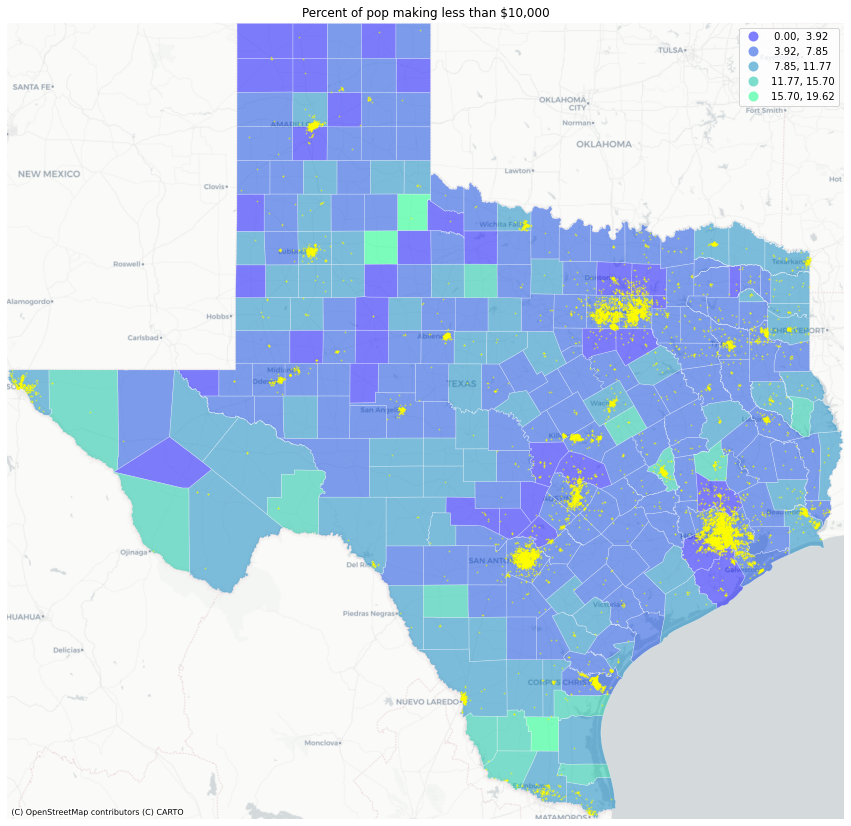

In [32]:
fig, ax = plt.subplots(figsize=(15, 15))

texasInc.plot(column='Percent Less than $10,000', 
            cmap= 'winter', 
            scheme='equal_interval',
            k=5, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.5, 
            ax=ax,
            legend=True
           )
ax.axis('off')
ax.set_title("Percent of pop making less than $10,000")

gvTexas.plot(ax=ax,
            color='yellow',
            markersize=1,
            alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In this case we mapped the percent of population making an income of $10,000 or less, the tracts with a high percentage of people in that category are categorized but the bright teal. The dark blue areas are census tracts where there are a lower percentage of people making in that bracket so it is assumed that this is where people live with a higher income. We can see that the yellow clusters of gun violence incidents line up on the higher income areas.

To compare we also created a map that maps the census tract of people making $200,000 or more.

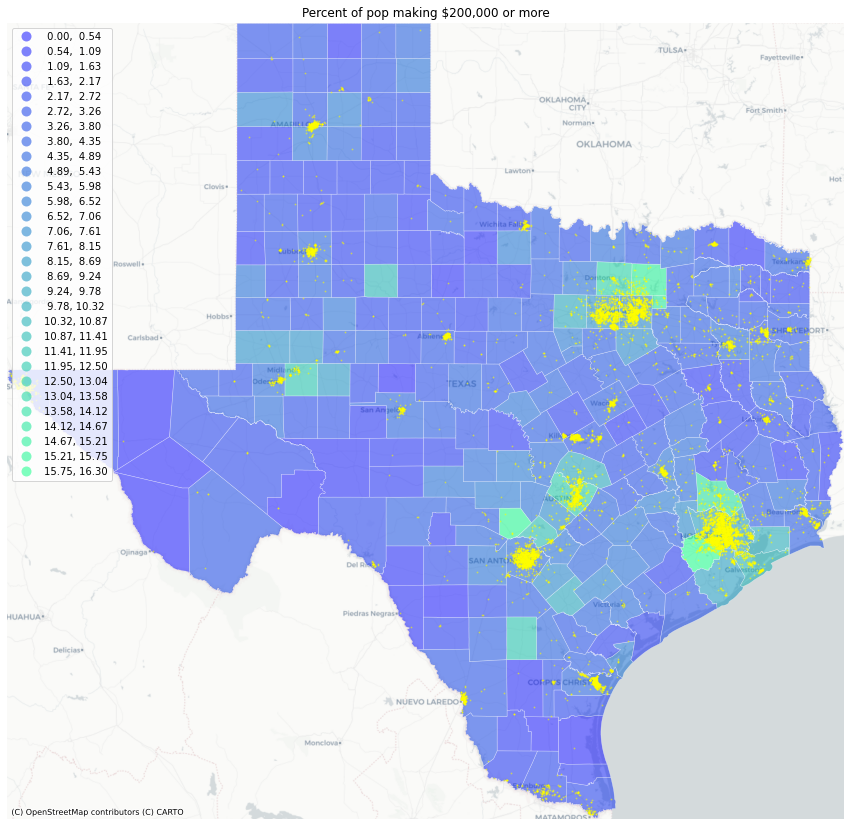

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))

texasInc.plot(column='Percent $200,000 or more', 
            cmap= 'winter', 
            scheme='equal_interval',
            k=30, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.5, 
            ax=ax,
            legend=True
           )
ax.axis('off')
ax.set_title("Percent of pop making $200,000 or more")

gvTexas.plot(ax=ax,
            color='yellow',
            markersize=1,
            alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

As we can see here our findings are the same as the one above. The clusters fall in high income areas.

## Texas Education Comparison
We will now import the education census data and follow through with a similar comparison as above

In [18]:
texasEdu = gpd.read_file('acs2019_5yr_B15002_05000US48289.geojson')

we will clean the data by removing the first two outliers, the US data and the overall state of Texas data

In [19]:
texasEdu = texasEdu.drop([0])
texasEdu = texasEdu.drop([1])

trim the columns

In [20]:
list(texasEdu)
columns_to_keep = ['geoid',
'name',
'B15002001',
'B15002011',
'B15002015',
'B15002028',
'B15002032',
'geometry']
texasEdu = texasEdu[columns_to_keep]

Rename the columns so they are usable and check to see if altered correctly

In [21]:
texasEdu.columns= ['geoid',
'name',
'Total',
'males with HS degree',
'males with BA degree',
'females with HS degree',
'females with BA degree',
'geometry']
texasEdu.head()

,geoid,name,Total,males with HS degree,males with BA degree,females with HS degree,females with BA degree,geometry
2,05000US48001,"Anderson County, TX",42073.0,10778.0,1511.0,5583.0,1359.0,"MULTIPOLYGON (((-95.67753 32.05163, -95.67360 ..."
3,05000US48003,"Andrews County, TX",10700.0,2136.0,326.0,1603.0,488.0,"MULTIPOLYGON (((-102.86649 32.08714, -102.8666..."
4,05000US48005,"Angelina County, TX",57275.0,9688.0,2944.0,8390.0,3469.0,"MULTIPOLYGON (((-94.86268 31.23236, -94.86227 ..."
5,05000US48007,"Aransas County, TX",17878.0,2590.0,1097.0,2990.0,1326.0,"MULTIPOLYGON (((-97.20401 28.08081, -97.19783 ..."
6,05000US48009,"Archer County, TX",6137.0,1188.0,435.0,987.0,560.0,"MULTIPOLYGON (((-98.75200 33.39587, -98.75494 ..."


Now I will normalize the raw data and add colums to my data that give %’s of each education level

In [22]:
texasEdu['percent males with HS degree'] = texasEdu['males with HS degree']/texasEdu['Total']*100
texasEdu['percent males with BA degree'] = texasEdu['males with BA degree']/texasEdu['Total']*100
texasEdu['percent females with HS degree'] = texasEdu['females with HS degree']/texasEdu['Total']*100
texasEdu['percent females with BA degree'] = texasEdu['females with BA degree']/texasEdu['Total']*100

we will combine all the levels of education to get a total amount of people educated

In [23]:
texasEdu['total educated'] = texasEdu['males with HS degree']+texasEdu['males with BA degree']+texasEdu['females with HS degree']+texasEdu['females with BA degree']

now we will get the percent of total per census tract 

In [24]:
texasEdu['percent total educated'] = texasEdu['total educated']/texasEdu['Total']*100

show the census tract groups in texas using black lines

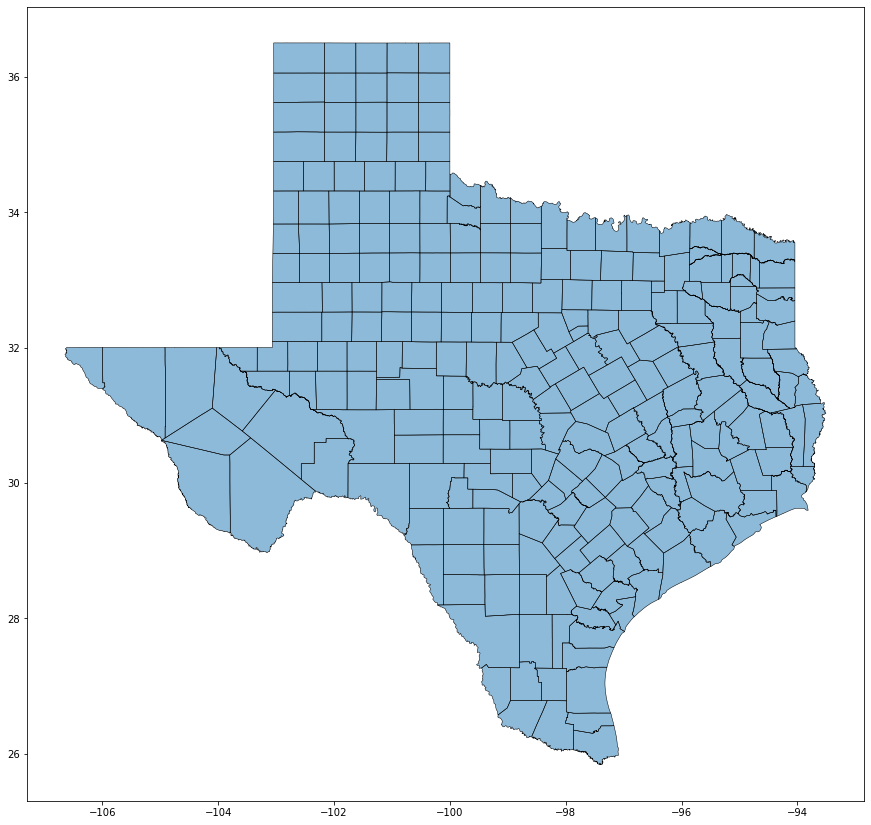

In [25]:
fig,ax = plt.subplots(figsize=(15,15))
texasEdu.plot(ax=ax,zorder=10,alpha=.5)
texasEdu.boundary.plot(ax=ax,color='black',zorder=15,lw=0.5)

we will now projecrt onto a mercator map

In [26]:
texasEdu = texasEdu.to_crs(epsg=3857)

plot. turn off the axis, and add a base map

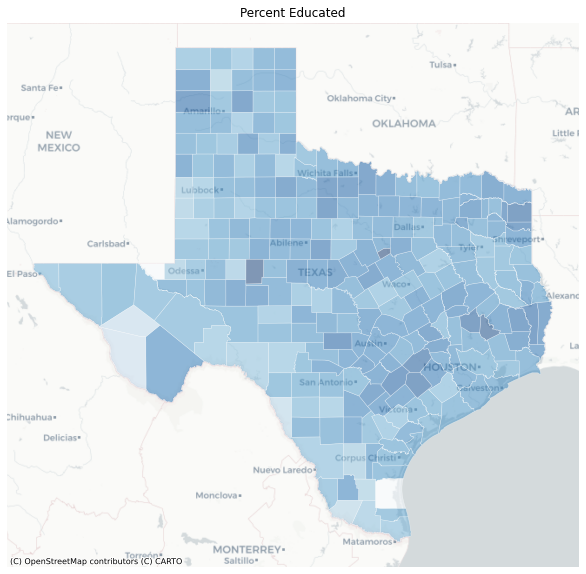

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))

texasEdu.plot(column='percent total educated', 
            cmap= 'Blues', 
            scheme='equal_interval',
            k=50, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.5, 
            ax=ax
           )
ax.axis('off')
ax.set_title("Percent Educated")

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Texas Education Vs Gun Violence Incidents
we will now compare the gun violence incidents as a scatterplot map to the chloropleth income map

first we will create bounds because we already imported the gun violence data

In [28]:
minx, miny, maxx, maxy = texasEdu.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-11871739.008039713
-10409267.286557566
2978926.9455577526
4369738.002232756


now we set up a plot canvas using plt.subplots. we plot the texas education census tract and texas gun violence data. we use the bounding box coodinates from earlier to set the x and y limits and add an agrument to create a margin around the total bounds. finally, no axis and add chloropleth basemap.

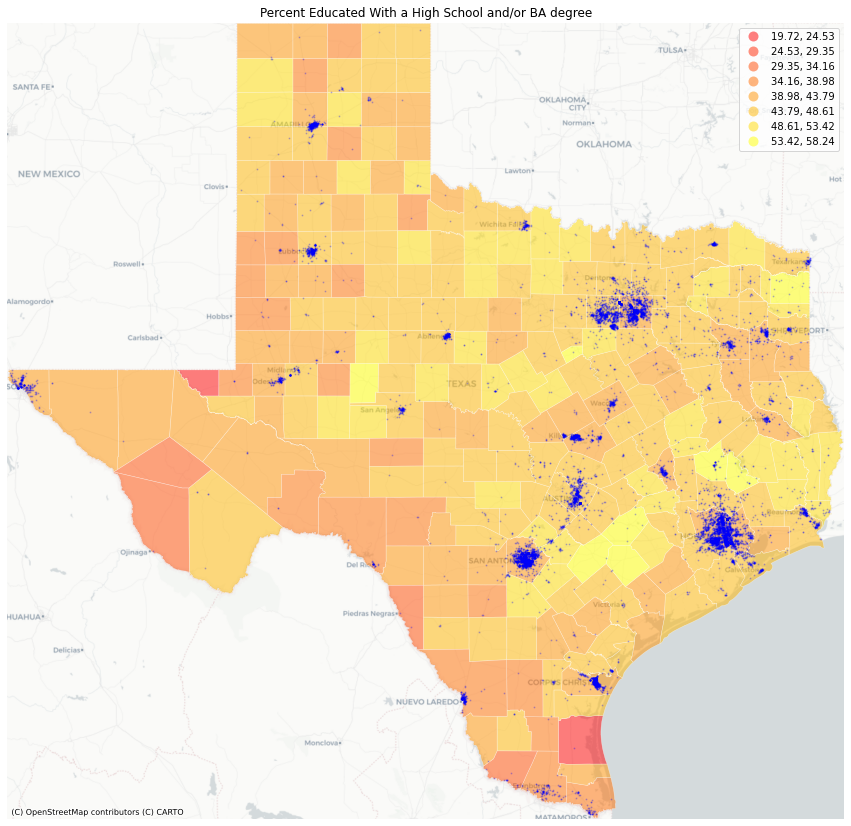

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))

texasEdu.plot(column='percent total educated', 
            cmap= 'autumn', 
            scheme='equal_interval',
            k=8, 
            edgecolor='white', 
            linewidth=0.5, 
            alpha=0.5, 
            ax=ax,
            legend=True
           )

ax.axis('off')
ax.set_title("Percent Educated With a High School and/or BA degree")

gvTexas.plot(ax=ax,
            color='blue',
            markersize=1,
            alpha=0.2)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The darker tracts on the map are a lower percentage of educated people and the bright/light yellow are tracts with a higher number of educated people. In this case we can see the clusters line up with mid or lower percentage of educated areas. However all the clusters are bordered by areas with higher percentages of education.